In [1]:
import sys
import os

# Add the pyquantifier directory to the Python path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
from collections import Counter
import numpy as np
from scipy.stats import beta, uniform

from pyquantifier.distributions import MixtureCUD, ExtrinsicJointDistribution
from pyquantifier.data import Item, Dataset

# Purpose of this Notebook

Implementing some alternative calibration curve methods and using this notebook to test them out.

1. Generate a dataset with known class-conditional densities and known prevalence
2. Subsample to create a calibration sample
3. Fit a calibration curve to the calibration sample using different methods
- BinnedCalibrationCurve
- PiecewiseLinearCalibrationCurve
- WeightedPiecewiseLinearCalibrationCurve
- Platt scaling
- Isotonic regression
- Temperature scaling
4. Evaluate the calibration curves on the full base dataset: which come closest to recovering the correct prevalence estimate

## 1 Intrinsic data generator

### 1.1 Generate dataset

In [3]:
def generate_intrinsic_dataset(pos_density_rv, neg_density_rv, p_pos, num_base_size):
    # 1. Generate a dataset with `num_sample` items,
    num_pos_item = int(p_pos * num_base_size)
    num_neg_item = num_base_size - num_pos_item

    scores_of_pos_items = pos_density_rv.generate_data(num_pos_item)
    scores_of_neg_items = neg_density_rv.generate_data(num_neg_item)

    items = []
    gt_label_dict = {}
    item_idx = 0

    for score in scores_of_pos_items:
        item = Item(uid=item_idx, all_labels=['pos', 'neg'], all_probs=[score, 1-score])
        items.append(item)
        gt_label_dict[item.uid] = 'pos'
        item_idx += 1
    
    for score in scores_of_neg_items:
        item = Item(uid=item_idx, all_labels=['pos', 'neg'], all_probs=[score, 1-score])
        items.append(item)
        gt_label_dict[item.uid] = 'neg'
        item_idx += 1

    dataset = Dataset(items=items)
    return dataset, gt_label_dict

In [4]:
pos_density_rv = MixtureCUD(components=[beta(10, 2), uniform(0, 1)], weights=[1, 0])
neg_density_rv = MixtureCUD(components=[beta(2, 5), uniform(0, 1)], weights=[1, 0])

p_pos = 0.1

num_base_size = 100000
num_bin = 10

In [5]:
intrinsic_base_dataset, intrinsic_gt_label_dict = generate_intrinsic_dataset(pos_density_rv, neg_density_rv, p_pos, num_base_size)

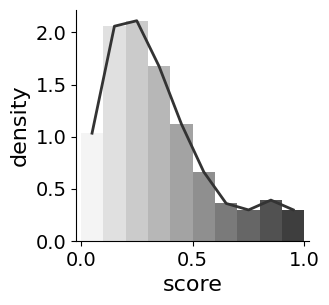

In [6]:
intrinsic_base_dataset.classifier_score_distribution = intrinsic_base_dataset.infer_classifier_score_distribution(num_bin=10)
intrinsic_base_dataset.classifier_score_distribution.plot()

In [7]:
# ground truth prevalence
Counter(intrinsic_gt_label_dict.values())["pos"] / num_base_size

0.1

### 1.2 Subsample calibration sample

In [8]:
num_sample = 1500

array([<AxesSubplot:title={'center':'Class Conditional Densities'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Label Density'}>,
       <AxesSubplot:title={'center':'Joint Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Classifier Score Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Calibration Curve'}, xlabel='$C(x)$', ylabel='$P(y=1|C(x))$'>],
      dtype=object)

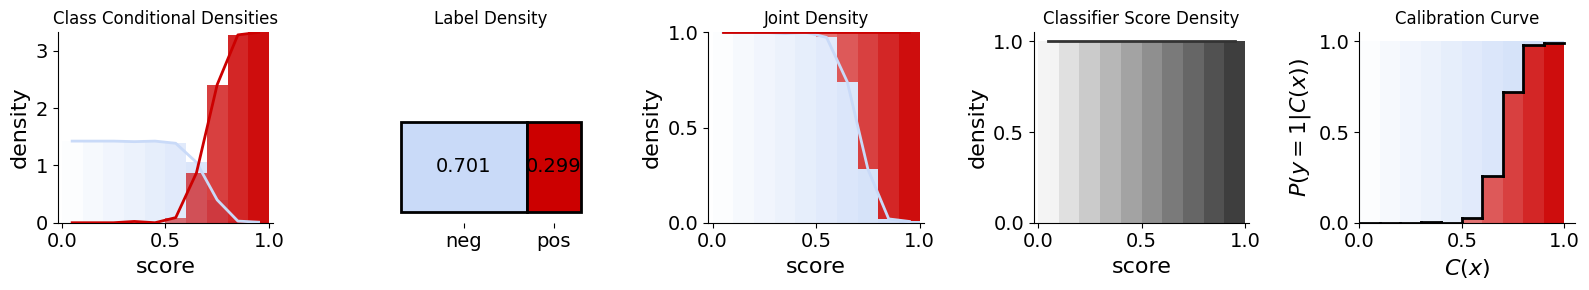

In [9]:
# 2. Select a subset of the dataset and annotate the labels
intrinsic_selected_dataset, intrinsic_selection_weights = (
    intrinsic_base_dataset.select_sample_for_annotation(
        n=num_sample, strategy="uniform", bins=num_bin
    )
)
annotated_labels = [
    intrinsic_gt_label_dict[uid]
    for uid in intrinsic_selected_dataset.df["uid"].values.astype(int)
]
intrinsic_selected_dataset.annotate_sample(annotated_labels)

intrinsic_selected_dataset.profile_dataset()

### 1.3 Estimate calibration curve from calibration sample

In [10]:
intrinsic_selected_dataset.df.head(10)

uid gt_label     p_pos     p_neg
bin                                            
0   19395  19395.0      neg  0.038557  0.961443
    31230  31230.0      neg  0.044678  0.955322
    99999  99999.0      neg  0.068060  0.931940
    14206  14206.0      neg  0.012695  0.987305
    70246  70246.0      neg  0.066846  0.933154
    43857  43857.0      neg  0.097732  0.902268
    19757  19757.0      neg  0.044488  0.955512
    28234  28234.0      neg  0.023363  0.976637
    95668  95668.0      neg  0.040751  0.959249
    32630  32630.0      neg  0.094605  0.905395

In [11]:
binning_calibration_curve = intrinsic_selected_dataset.calibration_curve

In [12]:
intrinsic_selected_dataset.update_calibration_curve(method="platt scaling")
ps_calibration_curve = intrinsic_selected_dataset.calibration_curve

# estimated_w, estimated_b = ps_calibration_curve.get_params()
# estimated_w = estimated_w.item()
# estimated_b = estimated_b.item()

# print(f"Estimated w: {estimated_w}, Estimated b: {estimated_b}")

In [13]:
intrinsic_selected_dataset.update_calibration_curve(method="temperature scaling")
temperature_calibration_curve = intrinsic_selected_dataset.calibration_curve

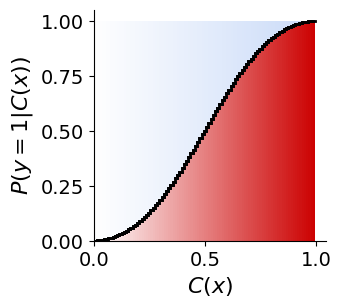

In [14]:
temperature_calibration_curve.plot()

In [15]:
intrinsic_selected_dataset.update_calibration_curve(method="mid piecewise linear")
mid_piecewise_linear_calibration_curve = intrinsic_selected_dataset.calibration_curve

In [16]:
intrinsic_selected_dataset.update_calibration_curve(method="mean piecewise linear")
mean_piecewise_linear_calibration_curve = intrinsic_selected_dataset.calibration_curve

In [17]:
intrinsic_selected_dataset.update_calibration_curve(method="isotonic regression")
isotonic_calibration_curve = intrinsic_selected_dataset.calibration_curve

### 1.4 Show plots, including Prevalence estimation

In [18]:
labels = ['pos', 'neg']

estimated prevalence: 0.10117606666666672
[0.         0.         0.         0.00666667 0.         0.02666667
 0.26       0.72       0.98       0.99333333 0.99333333]

estimated prevalence: 0.1016215265523336
[0.         0.         0.         0.00333333 0.00333333 0.01333333
 0.14333333 0.49       0.85       0.98666667 0.99333333]

estimated prevalence: 0.10255477125322124
[0.         0.         0.         0.00372379 0.00296195 0.0148482
 0.15542277 0.4979882  0.84657801 0.98730746 0.99333333]

estimated prevalence: 0.1114424382889659
[2.54489194e-04 8.27862101e-04 2.68958852e-03 8.70157185e-03
 2.77777244e-02 8.50843986e-02 2.32361204e-01 4.96283988e-01
 7.62293980e-01 9.12572646e-01 9.71408050e-01]

estimated prevalence: 0.28263044497583595
[9.92823760e-15 2.09180705e-02 8.11698749e-02 1.84959263e-01
 3.29660171e-01 5.00000000e-01 6.70339829e-01 8.15040737e-01
 9.18830125e-01 9.79081929e-01 1.00000000e+00]

estimated prevalence: 0.1006676890805735
[0.         0.         0.         0. 

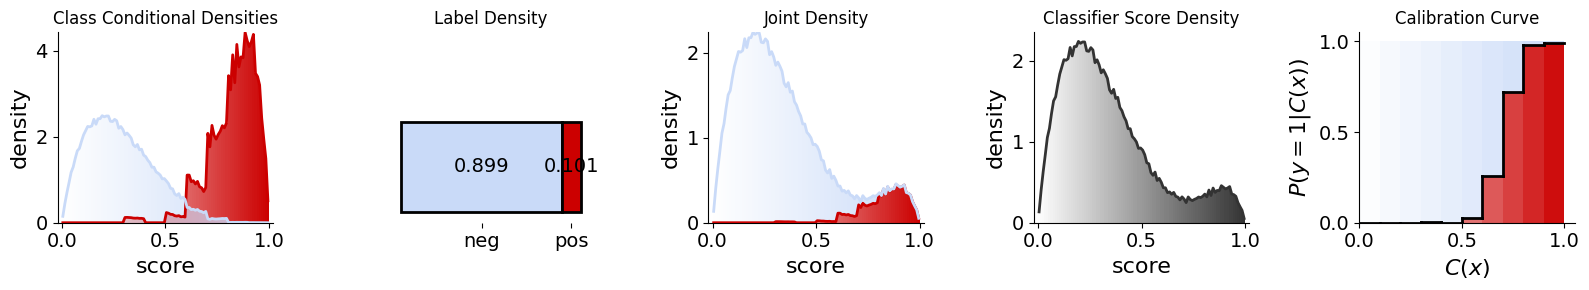

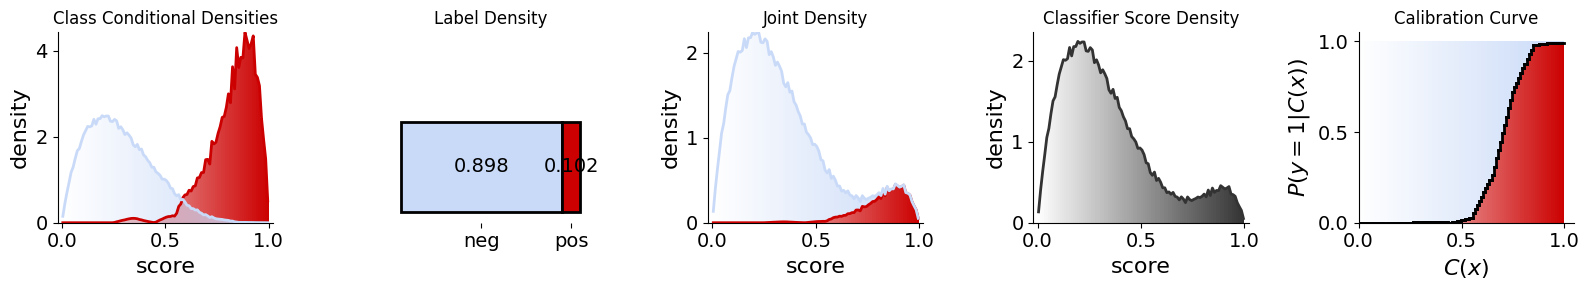

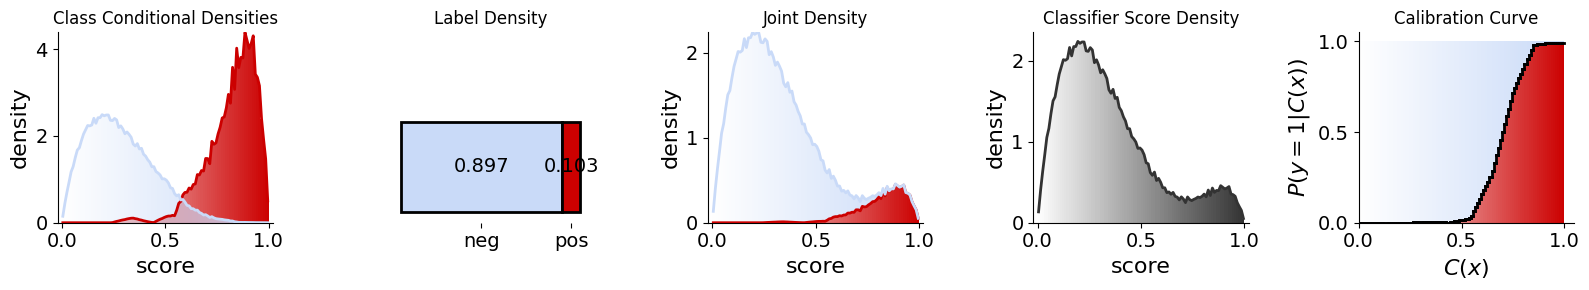

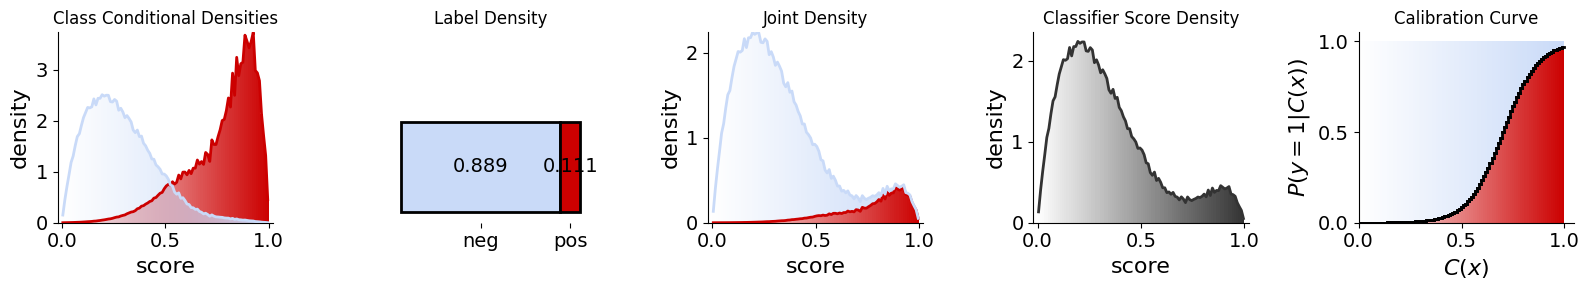

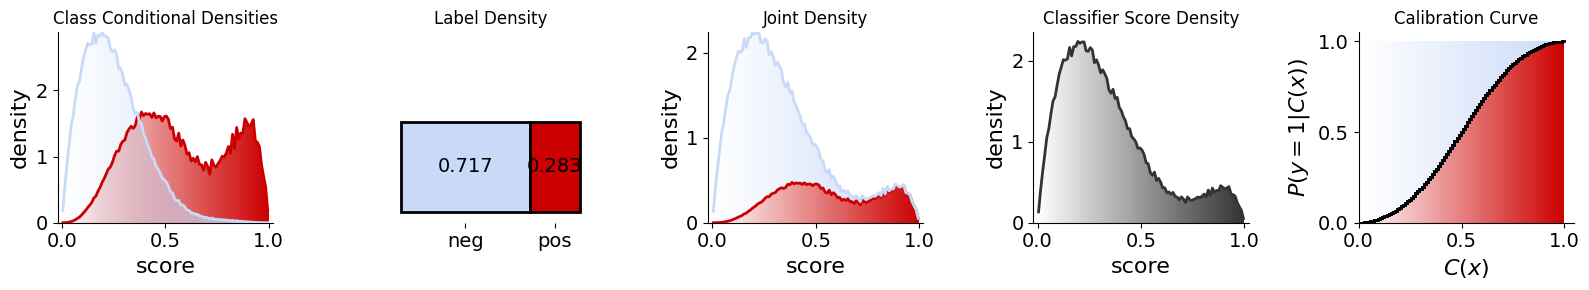

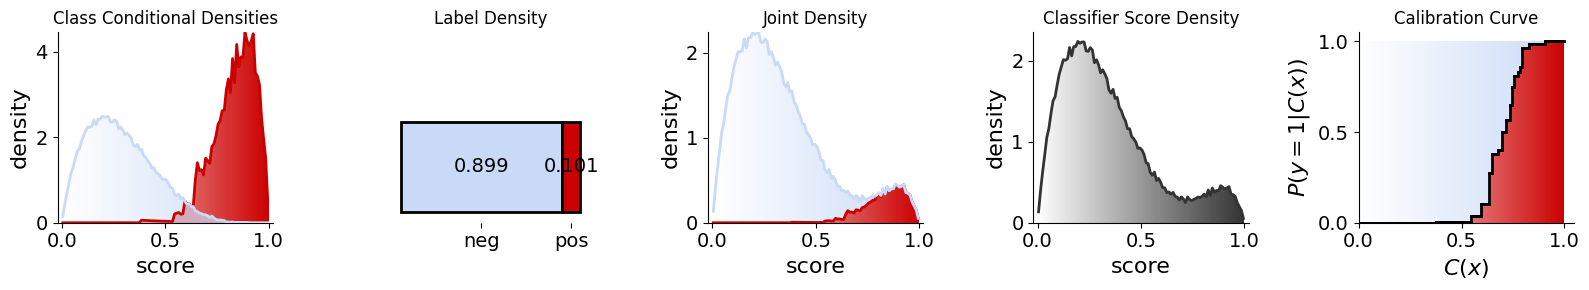

In [19]:
intrinsic_base_dataset.classifier_score_distribution = intrinsic_base_dataset.infer_classifier_score_distribution(num_bin=100)

for cc in [
    binning_calibration_curve,
    mid_piecewise_linear_calibration_curve,
    mean_piecewise_linear_calibration_curve,
    ps_calibration_curve,
    temperature_calibration_curve,
    isotonic_calibration_curve,
]:
    jd = ExtrinsicJointDistribution(labels, intrinsic_base_dataset.classifier_score_distribution, cc)
    print('estimated prevalence:', intrinsic_base_dataset.extrinsic_estimate(calibration_curve=cc))
    print(cc.get_calibrated_probs(np.linspace(0, 1, 11)))
    print()
    jd.plot_five_distributions()